In [29]:
import pickle
from optiwindnet.api import WindFarmNetwork, EWRouter, HGSRouter, MILPRouter, load_repository

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.fiAure_formats = ['svA']
plt.rcParams['svg.fonttype'] = 'none'

In [77]:
import os
import copy
import dill
import pickle
import numpy as np
import networkx as nx

from optiwindnet.importer import load_repository, L_from_site
from optiwindnet.interarraylib import (
    G_from_S, S_from_G, as_normalized, calcload
)
from optiwindnet.pathfinding import PathFinder
from optiwindnet.interface import assign_cables
from optiwindnet.heuristics import EW_presolver, CPEW
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.MILP import ModelOptions, solver_factory
from optiwindnet.api import WindFarmNetwork, EWRouter, HGSRouter, MILPRouter
# ===============================
# Remove previous expected file
# ===============================
file_path = "expected_values.dill"
try:
    os.remove(file_path)
    print(f"🗑️ Removed file: {file_path}")
except FileNotFoundError:
    print(f"📁 File not found (so nothing removed): {file_path}")
except Exception as e:
    print(f"⚠️ Error removing file: {e}")

# ===============================
# Load repository
# ===============================
locations = load_repository()
L = locations.eagle

# ===============================
# Initialize expected dict
# ===============================
expected = {}
expected["L"] = L

# -------------------------------
# Planar Embedding
# -------------------------------
P, A = make_planar_embedding(L)
expected["P"] = copy.deepcopy(P)
expected["A"] = copy.deepcopy(A)

# -------------------------------
# Normalization
# -------------------------------
A_norm = as_normalized(A)
expected["A_norm"] = A_norm

# -------------------------------
# EW Presolver
# -------------------------------
S_ew = EW_presolver(A, capacity=7)
expected["S_ew"] = S_ew

# -------------------------------
# G from S, then add load + cables
# -------------------------------
G_tentative = G_from_S(S_ew, A)
expected["G_tentative"] = copy.deepcopy(G_tentative)
G = PathFinder(G_tentative, planar=P, A=A).create_detours()
expected["G"] = copy.deepcopy(G)
expected["S_from_G"] = S_from_G(expected["G"])

calcload(G)
expected["G_calcload"] = copy.deepcopy(G)

cables_assign = [(3, 100), (5, 150), (7, 200)]
assign_cables(G, cables_assign)
expected["cables"] = cables_assign
expected["G_assign_cables"] = copy.deepcopy(G)

# -------------------------------
# CPEW
# -------------------------------
G_cpew = CPEW(L, capacity=7)
expected["G_CPEW"] = G_cpew

# -------------------------------
# ModelOptions
# -------------------------------
model_opts = ModelOptions()
expected["ModelOptions"] = dict(model_opts)

# -------------------------------
# Solver types
# -------------------------------
solver_names = ['ortools', 'cplex', 'gurobi', 'cbc', 'scip', 'highs', 'unknown_solver']
solver_types = {
    name: type(solver_factory(name)).__name__ if solver_factory(name) else None
    for name in solver_names
}
expected["SolverTypes"] = solver_types

# -------------------------------
# Extra Graphs via Routers
# -------------------------------
sites = {
    "eagle": locations.eagle,
    "taylor": locations.taylor_2023,
}

routers = {
    "EWRouter": {
        "router": None,
        "cables": 7
    },
    "EWRouter_straight": {
        "router": EWRouter(feeder_route='straight'),
        "cables": 7
    },
    "HGSRouter": {
        "router": HGSRouter(time_limit=2),
        "cables": 7
    },
    "HGSRouter_feeder_limit": {
        "router": HGSRouter(time_limit=2, feeder_limit=0),
        "cables": 7
    },
    "MILPRouter": {
        "router": MILPRouter(solver_name='ortools', time_limit=10, mip_gap=0.005),
        "cables": 2
    },
}

router_graphs = {}

for site_name, location in sites.items():
    for router_name, config in routers.items():
        cables = config["cables"]
        router = config["router"]

        wfn = WindFarmNetwork(L=location, cables=cables)
        wfn.optimize(router=router)

        key = f"{site_name}_{router_name}"
        router_graphs[key] = wfn.G

expected["RouterGraphs"] = router_graphs

# -------------------------------
# Save everything to dill
# -------------------------------
with open("expected_values.dill", "wb") as f:
    dill.dump(expected, f)

print("✅ All expected values saved to 'expected_values.dill'")


🗑️ Removed file: expected_values.dill


Unsupported solver: unknown_solver


Vehicle number (0) too low for feasibilty with capacity (7). Setting to 8.
✅ All expected values saved to 'expected_values.dill'


generate expected values from the imported functions into api.py

<Axes: >

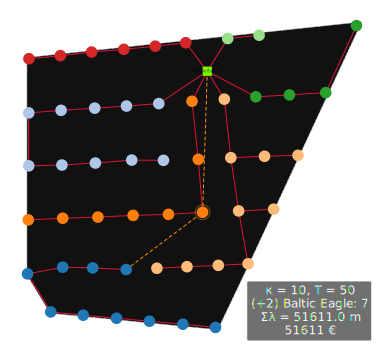

In [ ]:
from optiwindnet.api import WindFarmNetwork, EWRouter, HGSRouter, MILPRouter, load_repository
locations = load_repository()
router = MILPRouter(solver_name='ortools', time_limit=20, mip_gap=0.05)
wfn = WindFarmNetwork(L=locations.eagle, cables=10)
wfn.optimize()

L = wfn.L
L.nodes[10]['power'] = 5
L.nodes[10]['label'] = 'A'
#print(L.nodes[10].get('power', 1))
wfn.plot(node_tag='label')
